# Food Recognition model using PyTorch using Food101 dataset

* author: Amal Varghese
* email: officialamalv2004@gmail.com

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets

print("Using PyTorch version:", torch.__version__)
print("Using torchvision version:", torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Using PyTorch version: 2.7.0+cu118
Using torchvision version: 0.22.0+cu118
Device: cuda


# Getting the data ready
- using torchvision datasets
- apply a custom transform

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (224 , 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(                     # Normalize to ImageNet mean/std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224 , 224)),
    transforms.ToTensor(),
    transforms.Normalize(                     # Normalize to ImageNet mean/std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print(f"Train transform: {train_transform}")
print(f"Test transform: {test_transform}")

Train transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
)
Test transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [3]:
train_data = datasets.Food101(
    root="data",
    split="train",
    download=False,
    transform=train_transform,
)

test_data = datasets.Food101(
    root="data",
    split="test",
    download=False,
    transform=test_transform
)

print(f"Length of train_dataset: {len(train_data)}")
print(f"length of test data: {len(test_data)}")

Length of train_dataset: 75750
length of test data: 25250


Loading the small dataset using ImageFolder

In [4]:
from pathlib import Path

train_dir = Path("./customdata/train")
test_dir = Path("./customdata/test")

print(train_dir)
print(test_dir)

customdata\train
customdata\test


In [ ]:
from torchvision.datasets import ImageFolder

train_dataset_simple = ImageFolder(
    root=train_dir,
    transform=train_transform
)

test_dataset_simple = ImageFolder(
    root=test_dir,
    transform=test_transform
)

print(train_dataset_simple)
print(test_dataset_simple)

Dataset ImageFolder
    Number of datapoints: 30300
    Root location: customdata\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 10100
    Root location: customdata\test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


# Exploartory Data Analysis

In [6]:
image, label = train_data[0]
print(f"Image Shape: {image.shape} -> [color channels , height, width]")
classes = train_data.classes
print(f"Total number of classes:{len(classes)}")

Image Shape: torch.Size([3, 224, 224]) -> [color channels , height, width]
Total number of classes:101


In [7]:
image, label = train_dataset_simple[0]
print(f"Image Shape: {image.shape} -> [color channels, height, width]")
classes_ = train_dataset_simple.classes
print(f"Total number of classes:{len(classes_)}")
print(f"No. of train images: {len(train_dataset_simple)}")
print(f"No. of test images: {len(test_dataset_simple)}")

Image Shape: torch.Size([3, 224, 224]) -> [color channels, height, width]
Total number of classes:101
No. of train images: 30300
No. of test images: 10100


In [8]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up from notebooks/ to project root


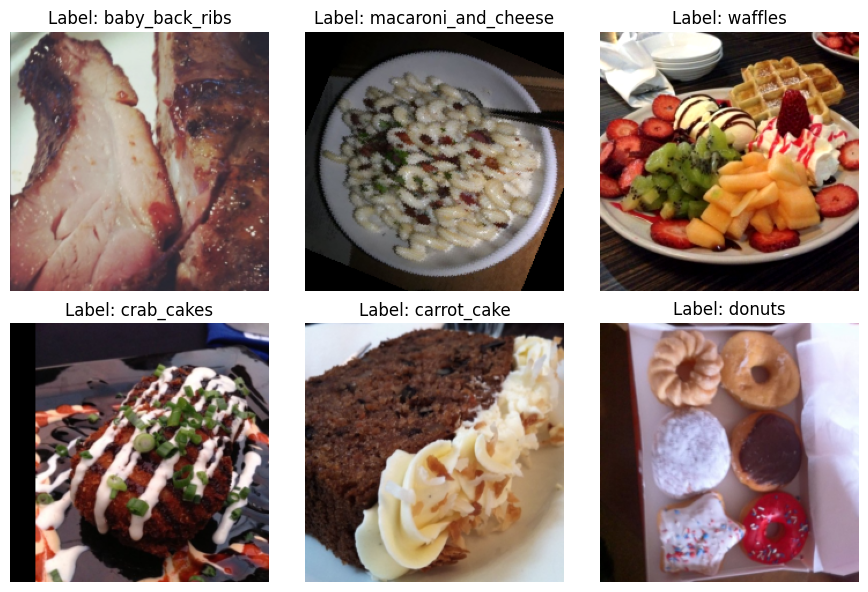

In [9]:
from helper.Visualize import plot_random_images
from helper.Visualize import plot_image

plot_random_images(train_data , num=6)

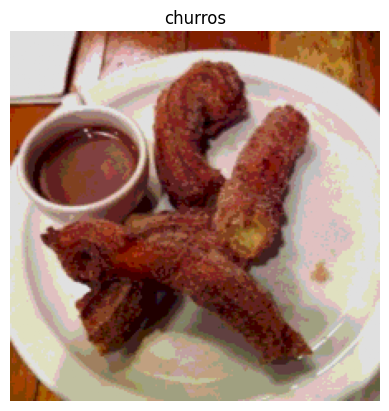

In [10]:
plot_image(train_data[0][0] , classes[train_data[0][1]])

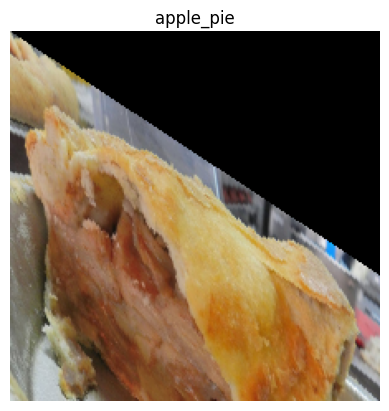

In [11]:
plot_image(train_dataset_simple[10][0], classes_[train_dataset_simple[10][1]])

# Creating Model

* starting with TinyVGG

In [12]:
class TinyVGG(nn.Module):
    def __init__(self , input_layer: int, hidden_layer:int, output_layer:int, dropout_rate: int = 0.25)->None:
        """
        A basic TinyVGG model to perform benchmark test for the model
        """
        super(TinyVGG, self).__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_layer, out_channels=hidden_layer, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(dropout_rate)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_layer, hidden_layer, 3, 1,1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),

            nn.Conv2d(hidden_layer, hidden_layer, 3, 1, 1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_layer*56*56 , output_layer)
        )
    
    def forward(self, x):
        return self.classifier(self.block_2(self.block_1(x)))

create a model instance

In [13]:
model_0 = TinyVGG(3 , 100 , len(classes_)).to(device)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [14]:
image, label = train_dataset_simple[0]
# Add batch dimension
image = image.unsqueeze(0)
model_0(image.to(device))

tensor([[ 1.1181e+00,  7.5711e-01,  1.1146e+00,  9.2906e-01,  9.5541e-01,
          1.6139e-01, -1.6645e-01, -9.4332e-03, -9.5212e-02,  4.6316e-01,
         -1.3036e+00,  1.3048e-03, -2.6069e-02, -4.9094e-01,  2.4275e-01,
         -4.8726e-01,  5.0261e-01,  7.0618e-01,  3.7145e-01,  2.8488e-01,
         -5.8365e-01,  3.7024e-01, -9.9979e-02, -4.0402e-02, -9.5949e-01,
         -4.8989e-02,  6.2039e-02,  4.3664e-01,  1.0311e+00, -7.2291e-01,
          1.5888e-01, -9.2716e-02,  2.1531e-01, -3.6559e-01,  8.7320e-01,
         -9.0213e-01,  2.4972e-01,  3.2938e-01, -1.1631e+00, -8.2435e-01,
         -1.0100e+00,  7.7902e-01, -1.0894e-01, -8.5266e-01, -6.6955e-01,
          1.5796e-01, -6.0874e-01,  3.9439e-01, -2.9971e-01, -4.0029e-01,
         -5.7662e-01, -5.5198e-01,  1.6603e+00, -1.3737e+00, -1.0471e+00,
         -1.7357e-01,  2.5239e-01, -4.8053e-01, -7.7119e-02,  1.5423e+00,
         -1.6641e+00, -1.0976e+00,  2.9471e-01, -1.0350e-01, -6.8188e-02,
          3.8698e-01, -4.7573e-01, -5.

This means that the model is successfully taking image values in the batchified form, so now we need to batchify it in the dataloaded

# creating dataLoader with small dataset

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8

train_dataloader = DataLoader(
    dataset=train_dataset_simple,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

test_dataloader = DataLoader(
    dataset=test_dataset_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(train_dataloader)
print(test_dataloader)

In [16]:
image, label = next(iter(train_dataloader))
print(f"Shape of Image:{image.shape} -> [Batches, color channels, height, weight]")

Shape of Image:torch.Size([8, 3, 224, 224]) -> [Batches, color channels, height, weight]


In [17]:
from torchinfo import summary

summary(model_0 , 
        input_size=(32,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 101]                 --
├─Sequential: 1-1                        [32, 100, 112, 112]       --
│    └─Conv2d: 2-1                       [32, 100, 224, 224]       2,800
│    └─BatchNorm2d: 2-2                  [32, 100, 224, 224]       200
│    └─ReLU: 2-3                         [32, 100, 224, 224]       --
│    └─Conv2d: 2-4                       [32, 100, 224, 224]       90,100
│    └─BatchNorm2d: 2-5                  [32, 100, 224, 224]       200
│    └─ReLU: 2-6                         [32, 100, 224, 224]       --
│    └─MaxPool2d: 2-7                    [32, 100, 112, 112]       --
│    └─Dropout2d: 2-8                    [32, 100, 112, 112]       --
├─Sequential: 1-2                        [32, 100, 56, 56]         --
│    └─Conv2d: 2-9                       [32, 100, 112, 112]       90,100
│    └─BatchNorm2d: 2-10                 [32, 100, 112, 112]       200
│

# performing training and testing on the model
- peforming on 3 classes and a smaller dataset for benchmark test

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min",
                                                       patience=5,
                                                       factor=0.1)

In [19]:
from helper.Process import run_train_test

result = run_train_test(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=torch.device(device),
    epochs=3
)

d:\FoodNet\mlvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File test


  0%|          | 0/3 [00:00<?, ?it/s]

Starting....

[] Allocated: 249.69 MB | Reserved: 2154.00 MB
processing train batch:0
processing train batch:1
processing train batch:2
processing train batch:3
processing train batch:4
processing train batch:5
processing train batch:6
processing train batch:7
processing train batch:8
processing train batch:9
processing train batch:10
processing train batch:11
processing train batch:12
processing train batch:13
processing train batch:14
processing train batch:15
processing train batch:16
processing train batch:17
processing train batch:18
processing train batch:19
processing train batch:20
processing train batch:21
processing train batch:22
processing train batch:23
processing train batch:24
processing train batch:25
processing train batch:26
processing train batch:27
processing train batch:28
processing train batch:29
processing train batch:30
processing train batch:31
processing train batch:32
processing train batch:33
processing train batch:34
processing train batch:35
processing tr

 33%|███▎      | 1/3 [25:18<50:36, 1518.09s/it]

Processing test Batch:{batch}
Epoch:0Train Loss:9.5650	Train Acc:0.0100	Test Loss:4.6152	Test Acc:0.0099
Starting....

[] Allocated: 623.43 MB | Reserved: 2158.00 MB
processing train batch:0
processing train batch:1
processing train batch:2
processing train batch:3
processing train batch:4
processing train batch:5
processing train batch:6
processing train batch:7
processing train batch:8
processing train batch:9
processing train batch:10
processing train batch:11
processing train batch:12
processing train batch:13
processing train batch:14
processing train batch:15
processing train batch:16
processing train batch:17
processing train batch:18
processing train batch:19
processing train batch:20
processing train batch:21
processing train batch:22
processing train batch:23
processing train batch:24
processing train batch:25
processing train batch:26
processing train batch:27
processing train batch:28
processing train batch:29
processing train batch:30
processing train batch:31
processing t

 67%|██████▋   | 2/3 [50:02<24:58, 1498.05s/it]

Processing test Batch:{batch}
Processing test Batch:{batch}
Epoch:1Train Loss:4.6196	Train Acc:0.0080	Test Loss:4.6152	Test Acc:0.0099
Starting....

[] Allocated: 623.43 MB | Reserved: 2158.00 MB
processing train batch:0
processing train batch:1
processing train batch:2
processing train batch:3
processing train batch:4
processing train batch:5
processing train batch:6
processing train batch:7
processing train batch:8
processing train batch:9
processing train batch:10
processing train batch:11
processing train batch:12
processing train batch:13
processing train batch:14
processing train batch:15
processing train batch:16
processing train batch:17
processing train batch:18
processing train batch:19
processing train batch:20
processing train batch:21
processing train batch:22
processing train batch:23
processing train batch:24
processing train batch:25
processing train batch:26
processing train batch:27
processing train batch:28
processing train batch:29
processing train batch:30
processi

100%|██████████| 3/3 [1:14:12<00:00, 1484.25s/it]

Processing test Batch:{batch}
Processing test Batch:{batch}
Epoch:2Train Loss:4.6166	Train Acc:0.0082	Test Loss:4.6152	Test Acc:0.0099
